In [2]:
import yt
import numpy as np
from matplotlib import pylab
from yt.analysis_modules.halo_analysis.api import HaloCatalog

/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Development of the HaloCatalog module has been moved to the yt_astro_analysis package. This version is deprecated and will be removed from yt in a future release. See https://github.com/yt-project/yt_astro_analysis for further information.
  after removing the cwd from sys.path.


In [3]:
from yt.funcs import mylog

# only critical log messages are printed
mylog.setLevel(50)

# the default log level is 20, which shows warnings and info messages
# mylog.setLevel(20)

# BH particle filters

In [4]:
@yt.particle_filter('p3_bh', ['creation_time', 'particle_mass', 'particle_type'])
def p3_bh(pfilter, data):
    return (data['particle_type'] == 1) & (data['creation_time'] > 0) & \
        (data['particle_mass'].in_units('Msun') > 1e-3)

# Load dataset

In [111]:
ds_s = yt.load('~jw254/data/SG64-2020/GravPotential/DD0100/output_0100')

In [112]:
halos_s = yt.load('~jw254/data/SG64-2020/rockstar_halos-jhw/halos_DD0100.0.bin')

In [113]:
ds_s.add_particle_filter('p3_bh')

Parsing Hierarchy : 100%|██████████| 1378/1378 [00:00<00:00, 10873.92it/s]


True

# Spherically-average approximation on one dataset

# My Thought Process
- for each halo:
    - find the gravitational potential function
    - find which black holes are inside
- for each black hole:
    - calculate the specific total energy E:
        - find gravitational potential from `find_field_values_at_point` for the BH --> potential energy
        - get the relative velocity --> kinetic energy
    - calculate the specific angular momentum L:
        - radius, relative position, relative velocity
    - E and L are constant for each BH
    - solve the function in Shi thesis for 2 roots to get the radii
    - from the radii, **get the sma and ecc**
        - **since we are enforcing spherical symmetry, would ecc be 0 and sma be just the radius???**
        - --> turns out NOT the case!!! got 2 different radii
        
## Use pickle to save data!

# Step 1: match each BH with the most massive halo that contains it

In [160]:
# starting STEP 1: get field info from ds
# use data_ds, ad_ds, and halos_bf
# CONVERT everything to the same unit
bh_id = ds_s.r['p3_bh', 'particle_index']
bh_pos = ds_s.r['p3_bh', 'particle_position'].to('pc') # (17, 3)
bh_vel = ds_s.r['p3_bh', 'particle_velocity'] # (17, 3)
bh_mass = ds_s.r['p3_bh', 'particle_mass']
hl_pos = halos_s.r['particle_position'].to('pc') # (260, 3)
hl_vel = halos_s.r['particle_velocity'] # (260, 3)
hl_mass = halos_s.r['particle_mass']
hl_vr = halos_s.r['virial_radius'].to('pc')
hl_id = halos_s.r['particle_identifier'] # it doesn't seem so helpful since the identifiers are not consistent across snapshots

In [205]:
# continue STEP 1 here: match each BH with the most massive halo that contains it
bh_hl_match = {}
for ibh in range(len(bh_id)):
    # remember the halo virial radii that contain the BH
    bh_in_halos_vr = [hl_vr[ihl] for ihl in range(len(hl_vr)) if sum((bh_pos[ibh] - hl_pos[ihl])**2)**0.5 <= hl_vr[ihl]]
    # choose the biggest virial radius and get its index
    biggest_halo_index = list(hl_vr).index(max(bh_in_halos_vr)) # what about when 2 biggest halos share the same radius???
    # match bh index with the biggest halo index
    bh_hl_match[ibh] = biggest_halo_index
bh_hl_match # need to be bh INDEX instead of bh ID, bh index will be used in below code

{0: 244,
 1: 244,
 2: 244,
 3: 244,
 4: 100,
 5: 120,
 6: 120,
 7: 120,
 8: 120,
 9: 120,
 10: 120,
 11: 100,
 12: 100,
 13: 100,
 14: 100,
 15: 100,
 16: 100}

# Step 2: get necessary data and profile plot non-0 gravitational potential vs radius

## Let's pick halo 244 and BH 0 as an example!

In [22]:
ibh = 0
ihl = 244
UE = ds_s.find_field_values_at_point('gravitational_potential', bh_pos[ibh]) * bh_mass[ibh] # get grav potential energy
v_rel_pos = bh_pos[ibh] - hl_pos[ihl]
v_rel_vel = bh_vel[ibh] - hl_vel[ihl]
m_rel_pos = sum(v_rel_pos**2)**0.5
m_rel_vel = sum(v_rel_vel**2)**0.5
KE = 0.5 * m_rel_vel**2 * bh_mass[ibh] # get kinetic energy
E = UE + KE
E = ds_s.arr(E[0])
Esp = E/bh_mass[ibh] # get specific total energy

In [23]:
L = ds_s.arr(np.cross(v_rel_pos.v, v_rel_vel.v), 'cm*pc/s') * bh_mass[ibh]
L = ds_s.arr(sum(L**2)**0.5).to('erg*s')
Lsp = L/bh_mass[ibh] # get specific angular momentum

In [163]:
# scale vr of halos_s to be the same code length as ds_s since from different codes
halos_vr = ds_s.arr(halos_s.r['halos', 'virial_radius'].to('pc').v, 'pc')

In [164]:
# scale pos of halos_s to be the same code length as ds_s since from different codes
halos_pos = ds_s.arr(halos_s.r['particle_position'].to('pc').v, 'pc')
# may not need to scale after all because it's already automatically scaled

In [26]:
# get a sphere centered at halo 244 and with its virial radius
sp = ds_s.sphere(halos_pos[ihl], halos_vr[ihl])

In [27]:
# Plot 0: unfiltered grav_potential vs radius within that sphere of halo 244
unfiltered_plot = yt.ProfilePlot(sp, 'radius', [('gas', 'gravitational_potential')], weight_field='density').set_log(("gas", "gravitational_potential"), False)

/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/site-packages/yt/visualization/profile_plotter.py:390: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes.set_yscale(yscale)


In [28]:
hl_profile = unfiltered_plot.profiles[0] # get the data from the above profile plot
# print the bin field, in this case radius
print(hl_profile.x)
# print the profiled grav_potential field
print(hl_profile["gas", "gravitational_potential"])
# in case of 0 grav potential --> eliminate from data

[8.05218672e+18 8.81028691e+18 9.63976099e+18 1.05473287e+19
 1.15403424e+19 1.26268467e+19 1.38156437e+19 1.51163639e+19
 1.65395448e+19 1.80967158e+19 1.98004920e+19 2.16646758e+19
 2.37043696e+19 2.59360971e+19 2.83779382e+19 3.10496746e+19
 3.39729506e+19 3.71714482e+19 4.06710792e+19 4.45001946e+19
 4.86898150e+19 5.32738813e+19 5.82895300e+19 6.37773937e+19
 6.97819309e+19 7.63517853e+19 8.35401808e+19 9.14053520e+19
 1.00011016e+20 1.09426889e+20 1.19729252e+20 1.31001565e+20
 1.43335147e+20 1.56829917e+20 1.71595196e+20 1.87750603e+20
 2.05427015e+20 2.24767631e+20 2.45929136e+20 2.69082961e+20
 2.94416681e+20 3.22135529e+20 3.52464061e+20 3.85647975e+20
 4.21956100e+20 4.61682576e+20 5.05149234e+20 5.52708206e+20
 6.04744778e+20 6.61680508e+20 7.23976644e+20 7.92137859e+20
 8.66716341e+20 9.48316264e+20 1.03759869e+21 1.13528690e+21
 1.24217231e+21 1.35912079e+21 1.48707979e+21 1.62708591e+21
 1.78027339e+21 1.94788321e+21 2.13127322e+21 2.33192910e+21] cm
[-1.21251484e+13  0.

In [29]:
# OR this step to eliminate 0 grav_potential from data
# filter out the 0 grav potential and form new lists of non-0 grav potential data
from yt.units import erg, g
non0_gravpotential = []
non0_radius = []
for index, potential in enumerate(hl_profile["gas", "gravitational_potential"]):
    if potential != 0 * erg/g:
        non0_gravpotential.append(potential)
        non0_radius.append(hl_profile.x[index])

In [30]:
non0_gravpotential = ds_s.arr(non0_gravpotential) # convert list to yt array

In [31]:
non0_radius = ds_s.arr(non0_radius).to('pc') # convert list to yt array

In [32]:
# prepare x and y data for interpolation
x = non0_radius
# y is equation 4.12 in Shi thesis --> find x where y is 0
y = x**(-2) + 2 * (non0_gravpotential - Esp) / Lsp**2
# what we need to do is interpolate to find at which radius y is 0

# Step 3: interpolate to find x roots that meet equation 4.12 in Shi thesis

## Apply: find 0 from interpolation on gravpotential vs radius

**what is UnivariateSpline thou?** --> 1-D smoothing spline fit to a given set of data points

In [33]:
# start interpolation
from scipy import interpolate
f = interpolate.UnivariateSpline(x, y, s=0)

In [34]:
# find roots from data without units
# no difference between with or without units!!!
yToFind = 0
yreduced = np.array(y) - yToFind
freduced = interpolate.UnivariateSpline(x, yreduced, s=0) # if s=0, If 0, spline will interpolate through all data points
freduced.roots()
# so there are 2 roots!

array([ 7.28601502, 45.35319356])

In [35]:
# convert roots to yt array with unit pc
from yt.units import pc
radius_roots = ds_s.arr(list(freduced.roots())*pc)

# Step 4: use 2 roots to calculate SMA and ECC

In [36]:
sma = sum(radius_roots)/2
sma

26.319604290999372 pc

In [37]:
ecc = abs(radius_roots[0]-radius_roots[1])/sum(radius_roots)
ecc

0.7231715589878149 dimensionless

# Step 5: extend the code to all BHs in this single snapshot output_0100

In [49]:
# extend the code to all BHs in a single snapshot

bh_sma = {} # dict to store SMA
bh_ecc = {} # dict to store ECC

for ibh, ihl in bh_hl_match.items(): # loop thru step 2 to step 4
    ######
    # compute Esp and Lsp
    UE = ds_s.find_field_values_at_point('gravitational_potential', bh_pos[ibh]) * bh_mass[ibh] # get grav potential energy
    v_rel_pos = bh_pos[ibh] - hl_pos[ihl]
    v_rel_vel = bh_vel[ibh] - hl_vel[ihl]
    m_rel_pos = sum(v_rel_pos**2)**0.5
    m_rel_vel = sum(v_rel_vel**2)**0.5
    KE = 0.5 * m_rel_vel**2 * bh_mass[ibh] # get kinetic energy
    E = UE + KE
    E = ds_s.arr(E[0])
    Esp = E/bh_mass[ibh] # get specific total energy
    L = ds_s.arr(np.cross(v_rel_pos.v, v_rel_vel.v), 'cm*pc/s') * bh_mass[ibh]
    L = ds_s.arr(sum(L**2)**0.5).to('erg*s')
    Lsp = L/bh_mass[ibh] # get specific angular momentum
    
    ######
    # scale halo data to be the same code length as ds_s since from different codes
    halos_vr = ds_s.arr(halos_s.r['halos', 'virial_radius'].to('pc').v, 'pc')
    halos_pos = ds_s.arr(halos_s.r['particle_position'].to('pc').v, 'pc')
    
    ######
    # get gravitational potential vs radius
    # get a sphere centered at halo 244 and with its virial radius
    sp = ds_s.sphere(halos_pos[ihl], halos_vr[ihl])
    # get profile plot of unfiltered grav_potential vs radius within that sphere of halo 244
    unfiltered_plot = yt.ProfilePlot(sp, 'radius', [('gas', 'gravitational_potential')], weight_field='density').set_log(("gas", "gravitational_potential"), False)
    # get the data from the above profile plot
    hl_profile = unfiltered_plot.profiles[0]
    
    ######
    # filter out the 0 grav potential and form new lists of non-0 grav potential data
    from yt.units import erg, g
    non0_gravpotential = []
    non0_radius = []
    for index, potential in enumerate(hl_profile["gas", "gravitational_potential"]):
        if potential != 0 * erg/g:
            non0_gravpotential.append(potential)
            non0_radius.append(hl_profile.x[index]) 
    # convert filtered data to yt array
    non0_gravpotential = ds_s.arr(non0_gravpotential) # convert list to yt array
    non0_radius = ds_s.arr(non0_radius).to('pc') # convert list to yt array
    
    ######
    # INTERPOLATION
    # prepare x and y data for interpolation
    x = non0_radius
    # y is equation 4.12 in Shi thesis --> find x where y is 0
    y = x**(-2) + 2 * (non0_gravpotential - Esp) / Lsp**2    
    # start interpolation
    from scipy import interpolate
    f = interpolate.UnivariateSpline(x, y, s=0)
    
    ######
    # FIND RADIUS ROOTS
    # find roots from data without units
    yToFind = 0
    yreduced = np.array(y) - yToFind
    freduced = interpolate.UnivariateSpline(x, yreduced, s=0) # if s=0, If 0, spline will interpolate through all data points
    freduced.roots()
    # convert roots to yt array with unit pc
    from yt.units import pc
    radius_roots = ds_s.arr(list(freduced.roots())*pc)
    #print(len(radius_roots))
    
    ######
    # calculate SMA & ECC
    if len(radius_roots) == 2:
        sma = sum(radius_roots)/2
        ecc = abs(radius_roots[0]-radius_roots[1])/sum(radius_roots)
    elif len(radius_roots) == 1:
        sma = sum(radius_roots)/2
        ecc = 0
    else:
        sma = None
        ecc = None
    
    ######
    # enter data into dicts
    bh_sma[int(bh_id[ibh])] = sma # match SMA to bh_id
    bh_ecc[int(bh_id[ibh])] = ecc # match ECC to bh_id
    
######

/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/site-packages/yt/visualization/profile_plotter.py:390: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes.set_yscale(yscale)
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/site-packages/yt/visualization/profile_plotter.py:390: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes.set_yscale(yscale)
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/site-packages/yt/visualization/profile_plotter.py:390: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes.set_yscale(yscale)
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/site-packages/yt/visualization/profile_plotter.py:390: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes.set_yscale(yscale)
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/pyth

In [52]:
bh_sma

{738519: 26.319604290999372 pc,
 738871: 43.670801847708795 pc,
 738896: 192.78588472835108 pc,
 738856: 163.48541635382082 pc,
 738899: 541.9801379218627 pc,
 738863: 457.640205193597 pc,
 738534: 409.04993085212783 pc,
 738866: 169.55987039794445 pc,
 738875: 321.91881598987777 pc,
 738514: 81.69225394234385 pc,
 738527: 90.33771455498083 pc,
 738532: 559.7410868424763 pc,
 738523: 71.71617766800537 pc,
 738543: None,
 738541: 188.4880918957387 pc,
 738850: 196.6005788668454 pc,
 738876: 57.86597018977659 pc}

In [53]:
bh_ecc

{738519: 0.7231715589878149 dimensionless,
 738871: 0.5957627277343422 dimensionless,
 738896: 0.6586224831867924 dimensionless,
 738856: 0.4505898124224237 dimensionless,
 738899: 0.5079950469934145 dimensionless,
 738863: 0.8497654473617463 dimensionless,
 738534: 0.7226140959684118 dimensionless,
 738866: 0.5487315345675507 dimensionless,
 738875: 0.7065981822787802 dimensionless,
 738514: 0.3367288463717035 dimensionless,
 738527: 0.6290615610433803 dimensionless,
 738532: 0.5980924684882635 dimensionless,
 738523: 0.3791164737815309 dimensionless,
 738543: None,
 738541: 0.5761433155042056 dimensionless,
 738850: 0.6211240046271178 dimensionless,
 738876: 0.3567605392871355 dimensionless}

# Step 6: save data with pickle

In [54]:
# save bh_sma

import pickle

with open('sp_avg_bh_sma_1ds.pkl', 'wb') as file:
    pickle.dump(bh_sma, file)
    
with open('sp_avg_bh_sma_1ds.pkl', 'rb') as file:
    sp_avg_bh_sma_1ds = pickle.load(file)
    
sp_avg_bh_sma_1ds

{738519: 26.319604290999372 pc,
 738871: 43.670801847708795 pc,
 738896: 192.78588472835108 pc,
 738856: 163.48541635382082 pc,
 738899: 541.9801379218627 pc,
 738863: 457.640205193597 pc,
 738534: 409.04993085212783 pc,
 738866: 169.55987039794445 pc,
 738875: 321.91881598987777 pc,
 738514: 81.69225394234385 pc,
 738527: 90.33771455498083 pc,
 738532: 559.7410868424763 pc,
 738523: 71.71617766800537 pc,
 738543: None,
 738541: 188.4880918957387 pc,
 738850: 196.6005788668454 pc,
 738876: 57.86597018977659 pc}

In [55]:
# save bh_ecc

import pickle

with open('sp_avg_bh_ecc_1ds.pkl', 'wb') as file:
    pickle.dump(bh_ecc, file)
    
with open('sp_avg_bh_ecc_1ds.pkl', 'rb') as file:
    sp_avg_bh_ecc_1ds = pickle.load(file)
    
sp_avg_bh_ecc_1ds

{738519: 0.7231715589878149 dimensionless,
 738871: 0.5957627277343422 dimensionless,
 738896: 0.6586224831867924 dimensionless,
 738856: 0.4505898124224237 dimensionless,
 738899: 0.5079950469934145 dimensionless,
 738863: 0.8497654473617463 dimensionless,
 738534: 0.7226140959684118 dimensionless,
 738866: 0.5487315345675507 dimensionless,
 738875: 0.7065981822787802 dimensionless,
 738514: 0.3367288463717035 dimensionless,
 738527: 0.6290615610433803 dimensionless,
 738532: 0.5980924684882635 dimensionless,
 738523: 0.3791164737815309 dimensionless,
 738543: None,
 738541: 0.5761433155042056 dimensionless,
 738850: 0.6211240046271178 dimensionless,
 738876: 0.3567605392871355 dimensionless}

# Investigate the case of no radius roots (BH #738543 in halo id #100)

/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]



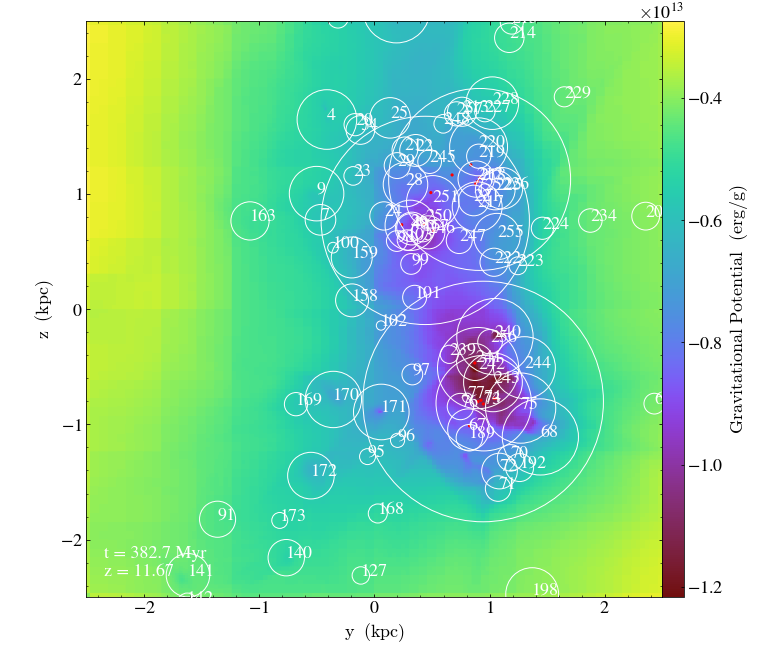

In [97]:
prj = yt.ProjectionPlot(ds_s, 'x', 'gravitational_potential', weight_field='density', width = (5, 'kpc'))
prj.annotate_particles((5, 'kpc'), p_size=10, ptype='p3_bh', col='red')
# annotate halos
prj.annotate_halos(halos_s, annotate_field='particle_identifier') #hc WORKS too
# timestamps & set limits for colorbar
prj.annotate_timestamp(redshift=True) # add timestamp and redshift
#prj.set_zlim('gravitational_potential', zmin=1.3e-27, zmax=1e-23) # set limits for colorbar

In [200]:
# info of BH 738543 (with no roots) and its host halo
bh_pos = ds_s.r['p3_bh', 'particle_position'].to('pc') # (17, 3)
for i in bh_hl_match.keys():
    if int(bh_id[i]) == 738543:
        print('index of BH in array:', i)
        print('particle_index of BH:', bh_id[i])
        print('position of BH:', bh_pos[i])
        print('index of host halo in array:', bh_hl_match[i])
        print('particle_identifier of halo:', hl_id[bh_hl_match[i]])

index of BH in array: 13
particle_index of BH: 738543.0 dimensionless
position of BH: [39198.3093268  40516.68504101 38675.51152998] pc
index of host halo in array: 100
particle_identifier of halo: 74.0 dimensionless


In [161]:
# create a sphere of the host halo
sp_test = ds_s.sphere(hl_pos[100], hl_vr[100])
print(hl_vr[100])
print(hl_pos[100].to('code_length')) # didn't need scaling at all. but didn't code_length did NOT work before???

1044.1226273864552 pc
[0.49597746 0.51196549 0.48984437] code_length


In [165]:
# create a sphere of the host halo, similar to the one above (this is for testing)
sp_test = ds_s.sphere(halos_pos[100], halos_vr[100])
print(halos_vr[100])
print(halos_pos[100].to('code_length')) # this is so weird

1044.1226273864552 pc
[0.49597746 0.51196549 0.48984437] code_length


/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]



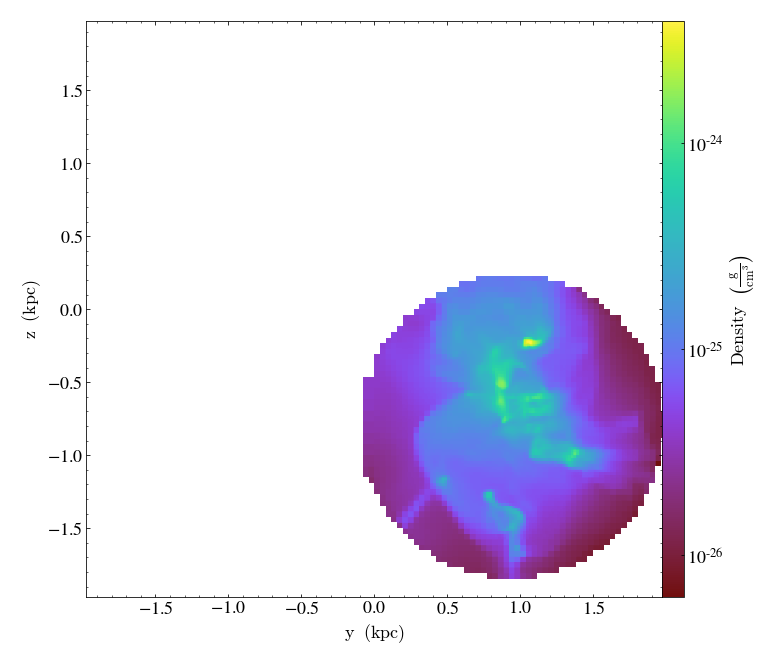

In [184]:
prj = yt.ProjectionPlot(ds_s, 'x', 'density', weight_field='density', data_source=sp_test)
prj.zoom(20)
# not centered at halo center

/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]



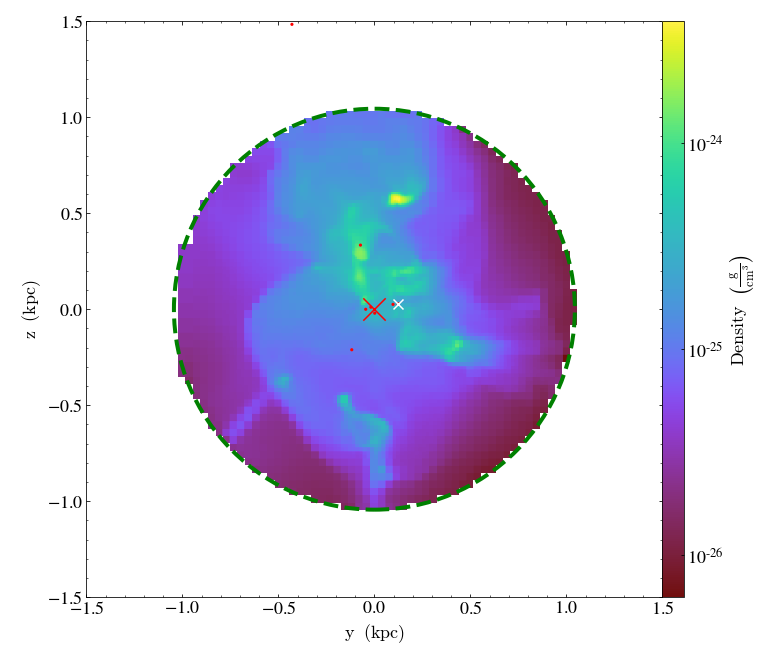

In [183]:
prj = yt.ProjectionPlot(ds_s, 'x', 'density', weight_field='density', data_source=sp_test, center=hl_pos[100], width=(3,'kpc'))

### annotate the BH #738543
bh_pos = ds_s.r['p3_bh', 'particle_position'].to('pc') # (17, 3)
prj.annotate_particles((5, 'kpc'), p_size=10, ptype='p3_bh', col='red')
prj.annotate_marker(bh_pos[13], coord_system='data', plot_args={'color':'white', 's':100}, marker = 'x')
# white cross is where the BH is, so it's INSIDE the halo!!!

### annotate halos
#prj.annotate_halos(halos_s, annotate_field='particle_identifier') #hc WORKS too
###DONT #prj.annotate_sphere(halos_pos[100], radius=halos_vr[100], coord_system='data', circle_args={'color':'green', 'linewidth':4, 'linestyle':'dashed'})
###DONT #prj.annotate_marker(hl_pos[100], coord_system='data', plot_args={'color':'red', 's':500}, marker = '*')
prj.annotate_marker([0,0], coord_system='plot', plot_args={'color':'red', 's':500}, marker = 'x')
prj.annotate_sphere([0,0], radius=halos_vr[100], coord_system='plot', circle_args={'color':'green', 'linewidth':4, 'linestyle':'dashed'})

### timestamps & set limits for colorbar
prj.annotate_timestamp(redshift=True) # add timestamp and redshift

#prj.set_zlim('gravitational_potential', zmin=1.3e-27, zmax=1e-23) ### set limits for colorbar

prj

### the problem is that I run the cell twice. DON'T run it twice (OR multiple similar cells)!!! will mess up the positions regardless of hl_pos or halos_pos
### the actual fix is that don't use halos_pos[100] or hl_pos[100] for position of annotate_marker or annotate_sphere, use [0,0] and coord_system='plot' instead

# Investigate the gravitational potential of BH #738543 (id #13) in halo id #100

In [187]:
ibh=13 # index of BH in array
ihl=100 # index of halo in array

######
# compute Esp and Lsp
UE = ds_s.find_field_values_at_point('gravitational_potential', bh_pos[ibh]) * bh_mass[ibh] # get grav potential energy
v_rel_pos = bh_pos[ibh] - hl_pos[ihl]
v_rel_vel = bh_vel[ibh] - hl_vel[ihl]
m_rel_pos = sum(v_rel_pos**2)**0.5
m_rel_vel = sum(v_rel_vel**2)**0.5
KE = 0.5 * m_rel_vel**2 * bh_mass[ibh] # get kinetic energy
E = UE + KE
E = ds_s.arr(E[0])
Esp = E/bh_mass[ibh] # get specific total energy
L = ds_s.arr(np.cross(v_rel_pos.v, v_rel_vel.v), 'cm*pc/s') * bh_mass[ibh]
L = ds_s.arr(sum(L**2)**0.5).to('erg*s')
Lsp = L/bh_mass[ibh] # get specific angular momentum

######
# scale halo data to be the same code length as ds_s since from different codes
halos_vr = ds_s.arr(halos_s.r['halos', 'virial_radius'].to('pc').v, 'pc')
halos_pos = ds_s.arr(halos_s.r['particle_position'].to('pc').v, 'pc')

######
# get gravitational potential vs radius
# get a sphere centered at halo 244 and with its virial radius
sp = ds_s.sphere(halos_pos[ihl], halos_vr[ihl])
# get profile plot of unfiltered grav_potential vs radius within that sphere of halo 244
unfiltered_plot = yt.ProfilePlot(sp, 'radius', [('gas', 'gravitational_potential')], weight_field='density').set_log(("gas", "gravitational_potential"), False)
# get the data from the above profile plot
hl_profile = unfiltered_plot.profiles[0]

######
# filter out the 0 grav potential and form new lists of non-0 grav potential data
from yt.units import erg, g
non0_gravpotential = []
non0_radius = []
for index, potential in enumerate(hl_profile["gas", "gravitational_potential"]):
    if potential != 0 * erg/g:
        non0_gravpotential.append(potential)
        non0_radius.append(hl_profile.x[index]) 
# convert filtered data to yt array
non0_gravpotential = ds_s.arr(non0_gravpotential) # convert list to yt array
non0_radius = ds_s.arr(non0_radius).to('pc') # convert list to yt array

######

/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/site-packages/yt/visualization/profile_plotter.py:390: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes.set_yscale(yscale)


In [208]:
non0_radius

YTArray([  3.13385762,   3.43410448,   3.76311723,   5.42606163,
           5.94591869,   6.51558192,   7.13982313,   7.82387128,
           8.57345634,   9.39485722,  10.29495441,  11.28128761,
          12.36211886,  13.54650179,  14.84435741,  16.26655725,
          17.82501441,  19.53278335,  21.40416927,  23.45484787,
          25.70199673,  28.16443917,  30.8628019 ,  33.81968785,
          37.05986547,  40.6104762 ,  44.50126185,  48.76481369,
          53.43684551,  58.55649273,  64.16664023,  70.31428158,
          77.05091269,  84.43296316,  92.52226897, 101.38659044,
         111.10017983, 121.74440332, 133.40842259, 146.18994165,
         160.19602529, 175.54399591, 192.36241627, 210.79216637,
         230.98762359, 253.11795582, 277.36853846, 303.94250727,
         333.06245992, 364.97232061, 399.93938327, 438.25655059,
         480.24478751, 526.25580979, 576.6750302 , 631.9247869 ,
         692.46788119, 758.81145418, 831.51123487, 911.17619523,
         998.47365127]) p

In [192]:
non0_gravpotential

YTArray([-1.68002847e+13, -1.67630116e+13, -1.68336910e+13,
         -1.67762480e+13, -1.67687545e+13, -1.67858434e+13,
         -1.67299678e+13, -1.68253347e+13, -1.67354667e+13,
         -1.67689628e+13, -1.67460405e+13, -1.67375782e+13,
         -1.67321860e+13, -1.67182657e+13, -1.67112922e+13,
         -1.66731855e+13, -1.66770107e+13, -1.66418657e+13,
         -1.66128659e+13, -1.65941854e+13, -1.65472949e+13,
         -1.65164140e+13, -1.64774945e+13, -1.64358524e+13,
         -1.63938641e+13, -1.63516188e+13, -1.63140049e+13,
         -1.62692107e+13, -1.62084289e+13, -1.61474494e+13,
         -1.60755168e+13, -1.60073665e+13, -1.59359643e+13,
         -1.58431417e+13, -1.57637005e+13, -1.56692815e+13,
         -1.55712674e+13, -1.54534461e+13, -1.53379388e+13,
         -1.52128713e+13, -1.50723151e+13, -1.49245636e+13,
         -1.47582960e+13, -1.45834405e+13, -1.44127998e+13,
         -1.42491988e+13, -1.40839598e+13, -1.38948090e+13,
         -1.36822668e+13, -1.34400842e+1

No handles with labels found to put in legend.


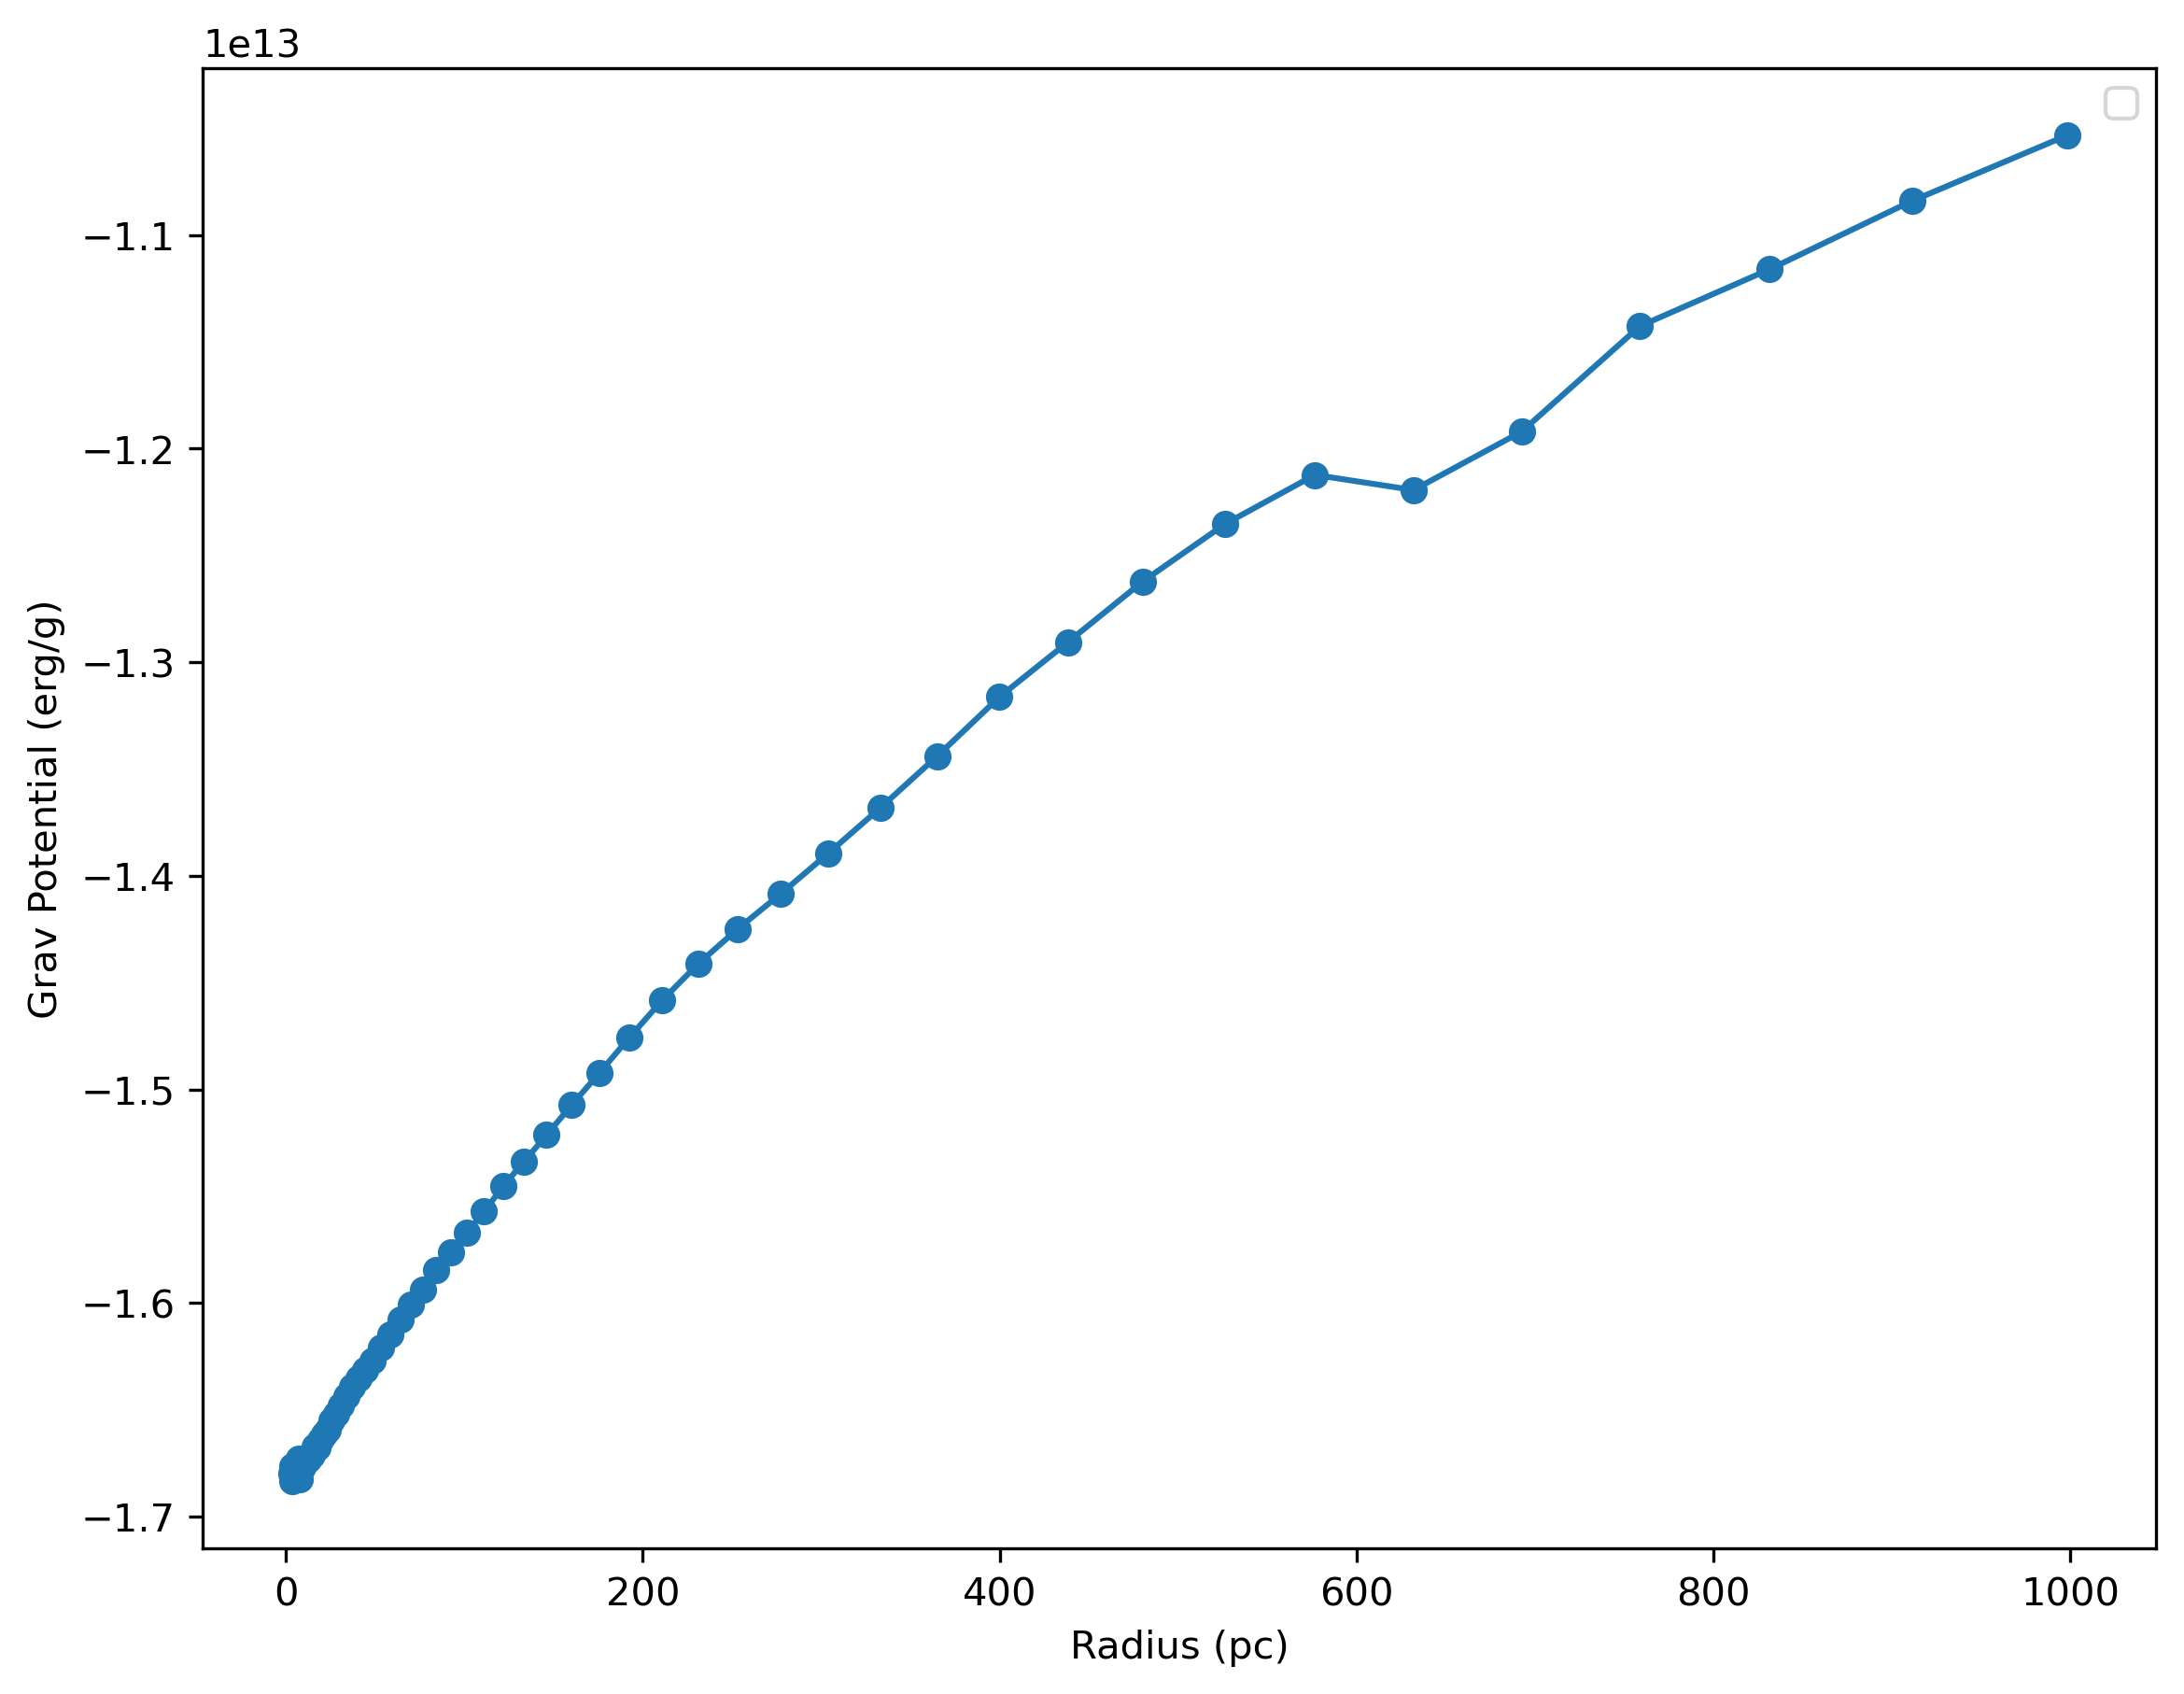

In [201]:
import matplotlib.pyplot as plt
# there should be a potential well???
plt.figure(figsize=(9, 7), dpi=300)
x = non0_radius
y = non0_gravpotential
plt.plot(x, y, marker='o')
plt.xlabel('Radius (pc)')
plt.ylabel('Grav Potential (erg/g)')
plt.legend()

No handles with labels found to put in legend.


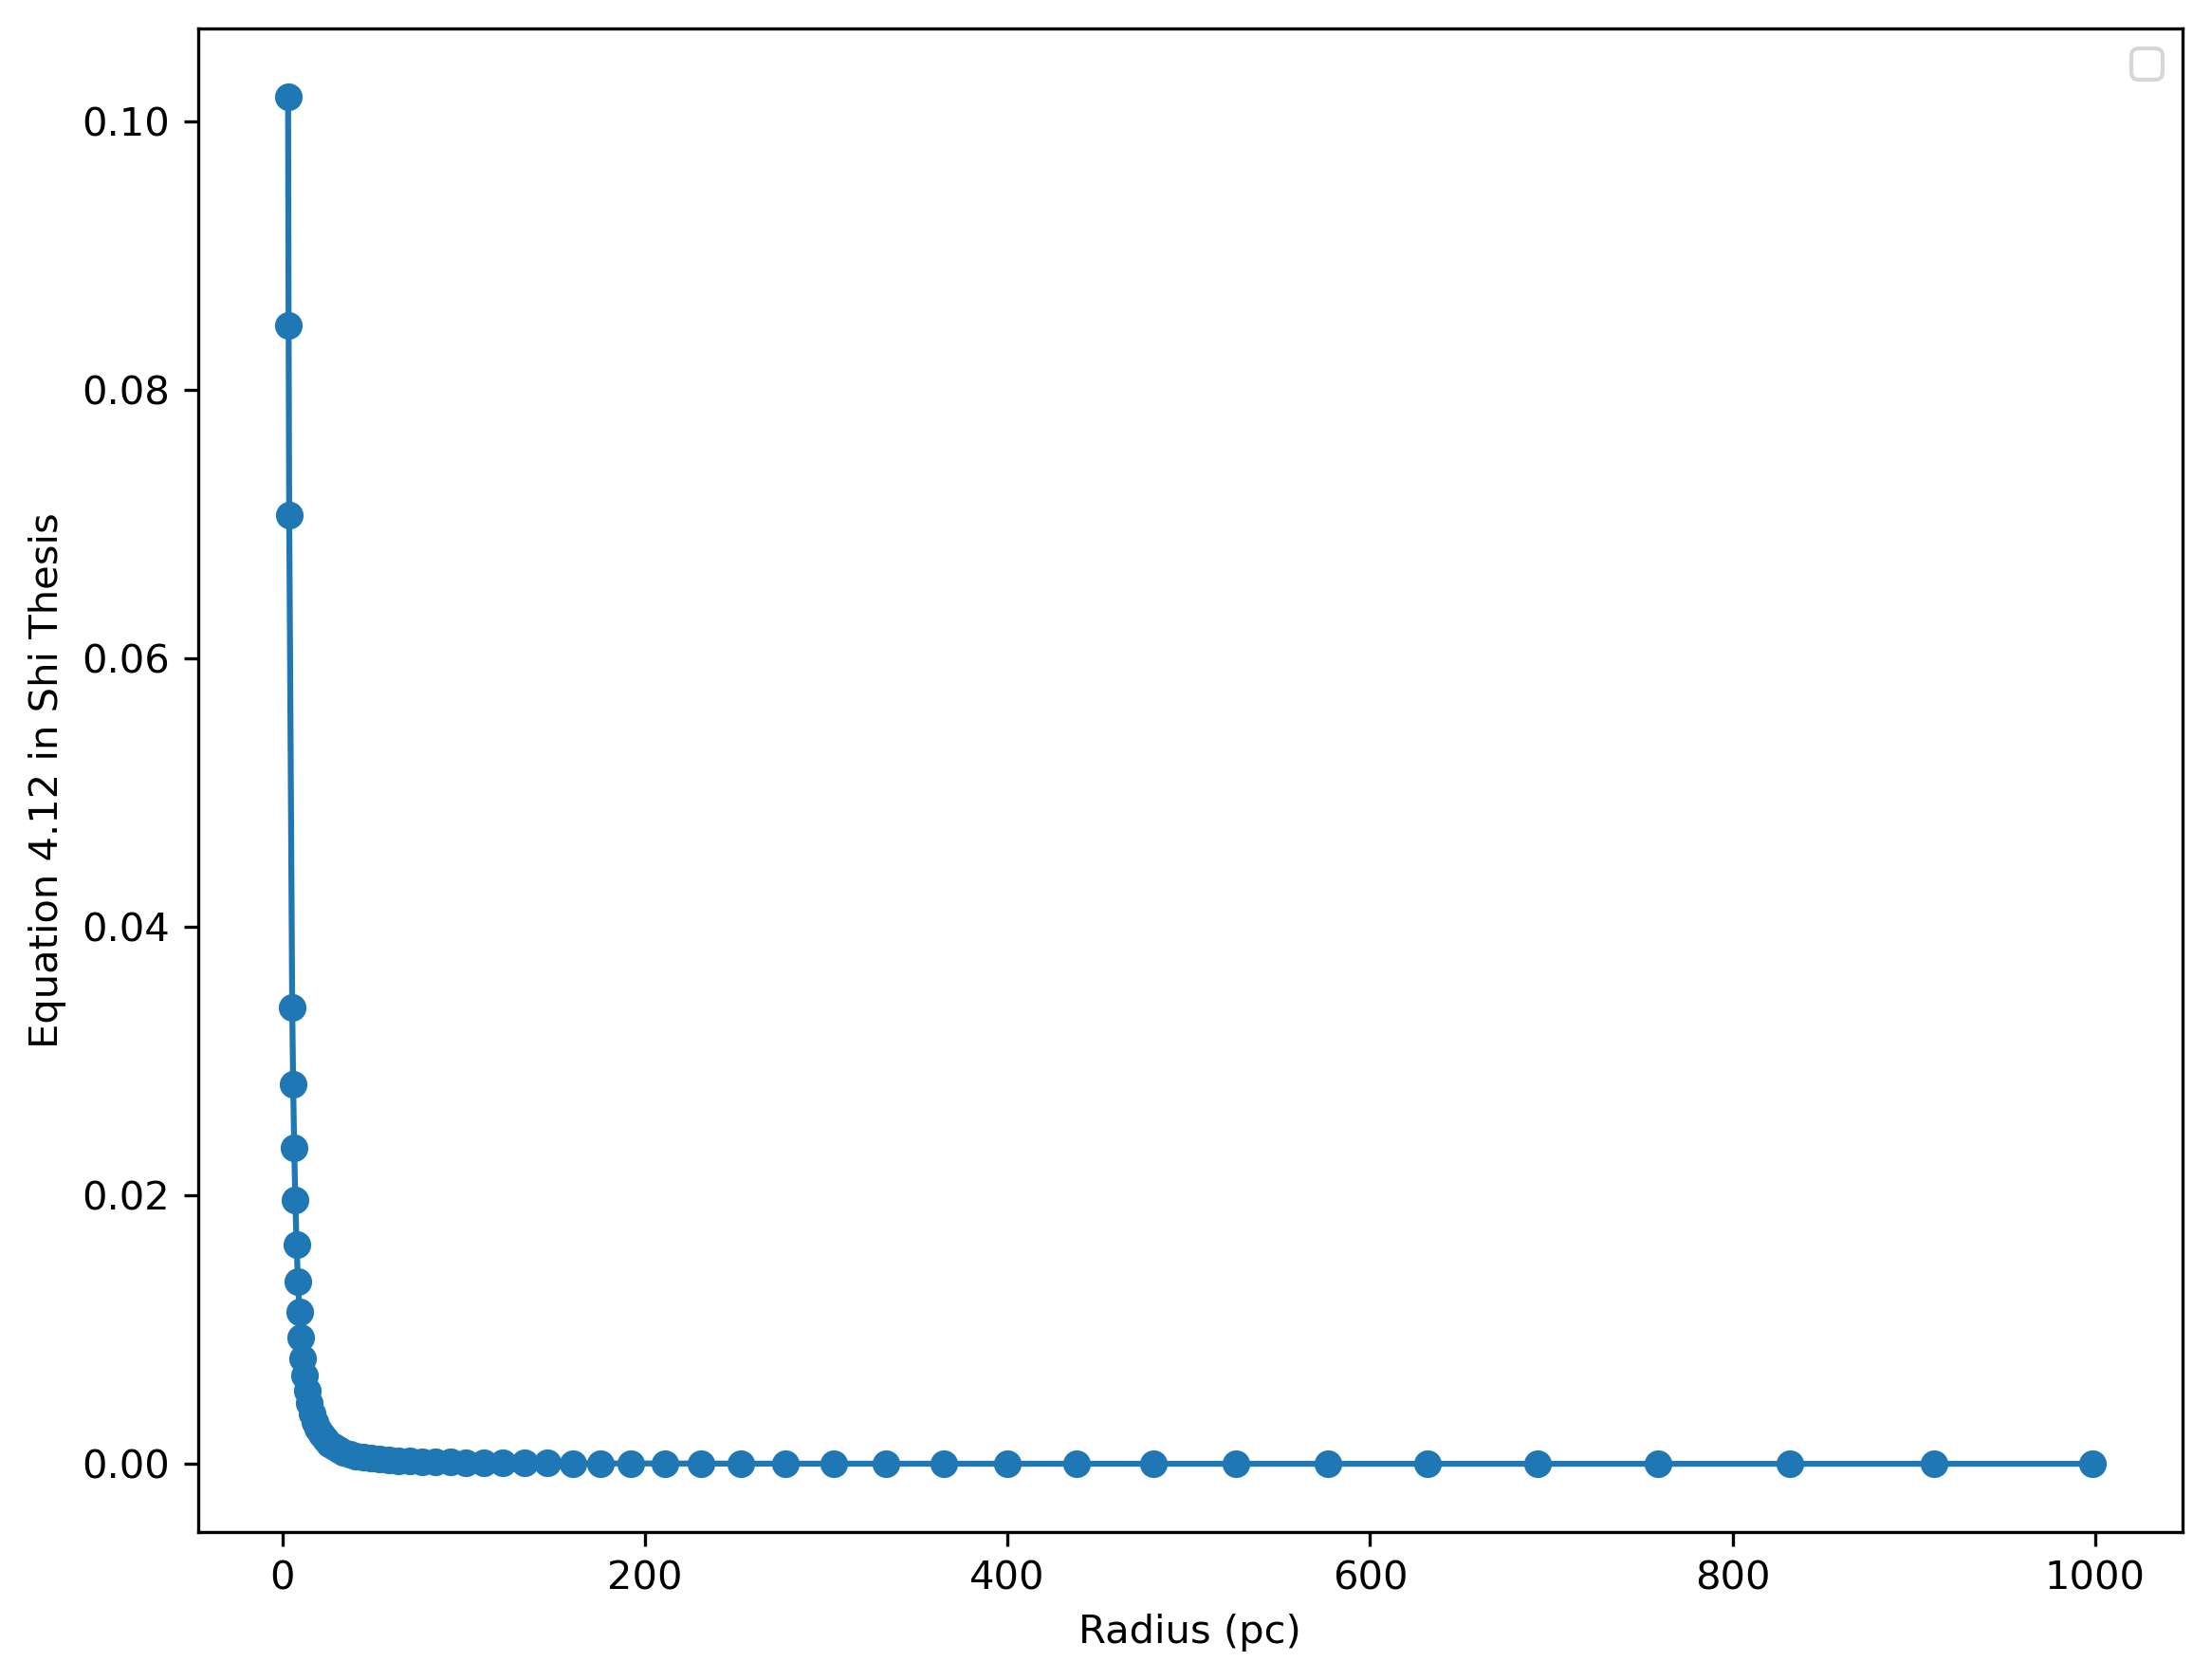

In [207]:
import matplotlib.pyplot as plt
# Plot: y is equation 4.12 in Shi thesis
plt.figure(figsize=(9, 7), dpi=300)
x = non0_radius
y = x**(-2) + 2 * (non0_gravpotential - Esp) / Lsp**2 # find where y is 0
plt.plot(x, y, marker='o')
plt.xlabel('Radius (pc)')
plt.ylabel('Equation 4.12 in Shi Thesis')
plt.legend()
# what we need to do is interpolate to find at which radius y is 0

In [209]:
y # Equation 4.12 never really reaches 0

YTArray([1.01821960e-01, 8.47955303e-02, 7.06162201e-02, 3.39649108e-02,
         2.82853773e-02, 2.35555620e-02, 1.96166553e-02, 1.63364033e-02,
         1.36046674e-02, 1.13297259e-02, 9.43519478e-03, 7.85746269e-03,
         6.54355526e-03, 5.44935634e-03, 4.53812680e-03, 3.77927092e-03,
         3.14730913e-03, 2.62102251e-03, 2.18274031e-03, 1.81774662e-03,
         1.51378633e-03, 1.26065357e-03, 1.04984907e-03, 8.74294806e-04,
         7.28096317e-04, 6.06344799e-04, 5.04952283e-04, 4.20514391e-04,
         3.50196011e-04, 2.91636109e-04, 2.42868463e-04, 2.02255631e-04,
         1.68433986e-04, 1.40267927e-04, 1.16811731e-04, 9.72778346e-05,
         8.10103564e-05, 6.74630993e-05, 5.61811883e-05, 4.67858213e-05,
         3.89615371e-05, 3.24456213e-05, 2.70192955e-05, 2.25003588e-05,
         1.87370762e-05, 1.56030878e-05, 1.29931669e-05, 1.08196874e-05,
         9.00966977e-06, 7.50234004e-06, 6.24708697e-06, 5.20174242e-06,
         4.33122072e-06, 3.60627583e-06, 3.00255670

In [196]:
######
# INTERPOLATION
# prepare x and y data for interpolation
x = non0_radius
# y is equation 4.12 in Shi thesis --> find x where y is 0
y = x**(-2) + 2 * (non0_gravpotential - Esp) / Lsp**2    
# start interpolation
from scipy import interpolate
f = interpolate.UnivariateSpline(x, y, s=0)

######
# FIND RADIUS ROOTS
# find roots from data without units
yToFind = 0
yreduced = np.array(y) - yToFind
freduced = interpolate.UnivariateSpline(x, yreduced, s=0) # if s=0, If 0, spline will interpolate through all data points
freduced.roots()
# convert roots to yt array with unit pc
from yt.units import pc
radius_roots = ds_s.arr(list(freduced.roots())*pc)
print('radius roots that satisfy the equation 4.12 in Shi thesis:', radius_roots)
#print(len(radius_roots))

######
# calculate SMA & ECC
if len(radius_roots) == 2:
    sma = sum(radius_roots)/2
    ecc = abs(radius_roots[0]-radius_roots[1])/sum(radius_roots)
elif len(radius_roots) == 1:
    sma = sum(radius_roots)/2
    ecc = 0
else:
    sma = None
    ecc = None

######
print('semi-major axis:', sma)
print('eccentricity:', ecc)

######

radius roots that satisfy the equation 4.12 in Shi thesis: [] pc
semi-major axis: None
eccentricity: None


# Questions
1. Don't we have the gravitational potential vs radius plot already? Why plot gravitational potential vs radius based on the equation in Shi thesis again?
2. The **non0_gravpotential** is actually the spherically-averaged potential to be used in equation 4.12???
3. **Since we are enforcing spherical symmetry, would ecc be 0 and sma be just the radius???** Why is it contradictory to what we got (2 different radii)???
4. What to do in case of no roots? In case of 1 root?
5. Why can't I use annotate_marker with position in `coord_system='data'`? It messes up the field data of the positions of the halos.
6. There should be a potential well in grav_potential vs radius, but I don't see it anywhere?

# Answers
1. I got it! The gravitational potential from the field is not what we are looking for. We are looking for the SPHERICALLY-AVERAGED POTENTIAL, which is given by the equation 4.12 in Shi thesis.
2. Another way to understand equation 4.12 is that the gravitational potential in plot 3 and plot 1 can be thought of as one, and we need to find where those 2 datasets overlap because that is where equation 4.12 is met?


4. Investigate more with plot --> it's actually INSIDE the halo!!! but it doesn't satisfy the equation --> let's investigate its gravitational potential function! --> so it really has no roots. **What should I do in this case?**
5. Use position in `coord_system='plot'` instead. But why does this happen?